##  lasso 回归

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
import seaborn as sns #用于绘图：分析结果的可视化。封装更好。
from IPython.display import display

#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

In [2]:
Y_Standard = False
# 生成的结果文件编号
out_id = 1
out_name = '%ssummit=0.1-fe-pay-%s-%s.csv'

path  = '../data/new/'
path_train = '../data/new/train=0.1/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'

In [3]:
#读取训练数据: 
train = pd.read_csv(path_train + 'train=0.1-fe-pay.csv')
train.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,878466,125,4788674.0000,4235090.0000,3014688.0000,2102260.0000,1045000.0000,0.0000,8070672.0000,5001865.0000,...,0,0,0,14,14,12,31.3333,2.9800,2,2.9800
1,2078768,114,9964534.0000,6394213.0000,4504160.0000,2281412.0000,1702932.0000,0.0000,12889437.0000,5445916.0000,...,5,0,2,109,109,100,207.1667,1.9800,2,1.9800
2,66889,121,1853155.0000,545664.0000,1020000.0000,0.0000,503000.0000,0.0000,3476295.0000,384528.0000,...,3,0,0,6,6,4,24.8333,0.9900,1,0.9900
3,3169202,104,14578830.0000,12919086.0000,6907604.0000,5026825.0000,3787258.0000,1565976.0000,18031829.0000,15577385.0000,...,76,59,63,147,147,135,343.3333,0.9900,1,0.9900
4,878159,125,2462137.0000,1431281.0000,1000000.0000,0.0000,506000.0000,0.0000,2634777.0000,226953.0000,...,7,0,3,4,4,4,7.5000,0.9900,1,0.9900


In [10]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415.0000,138362.0000,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.0000,0.0000,0
1,14934,94,10000.0000,600.0000,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.1667,0.0000,0
2,14935,94,10000.0000,3700.0000,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.0000,0.0000,0
3,14936,94,210000.0000,0.0000,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.6667,0.0000,0
4,14937,94,11500.0000,3700.0000,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.3333,0.0000,0


In [11]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train[target].values
train_X = train.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test.drop([id], axis = 1)

## 数据标准化

In [14]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X = ss_X.fit_transform(train_X)
test_X = ss_X.transform(test_X)

if Y_Standard:
    train_y = ss_y.fit_transform(train_y.reshape(-1, 1))

In [15]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 模型训练
### 正则化的线性回归（L1正则 --> Lasso）

In [30]:
%%time
#正则项系数
# alphas = [0.1, 1, 10, 100, 1000, 10000, 10000]
alphas = [10, 50, 80, 81, 82, 83, 85, 100, 1000]

# Lasso 模型实例
lasso = LassoCV(alphas=alphas)

#进行模型训练
lasso.fit(train_X, train_y)

Wall time: 1.09 s


best alpha is: 82


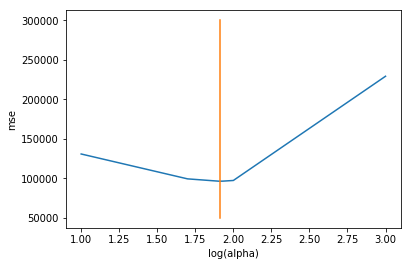

In [31]:
## 3.1 Lasso 模型评价
mses = np.mean(lasso.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(lasso.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(lasso.alpha_)*np.ones(3), [50000, 100000, 300000])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 
print ('best alpha is:', lasso.alpha_)

In [32]:
## 3.2 Lasso 模型与 LinearRegression 的比较
# 使用 Lasso 模型自带的评估模块（r2_score），并输出评估结果
#训练集
lassoScoreTrain = lasso.score(train_X, train_y)
print('The value of default measurement of Lasso on train is', lassoScoreTrain) 

The value of default measurement of Lasso on train is 0.630530814493


In [33]:
#对测试数据进行预测
lasso_y_predict_test = lasso.predict(test_X)
print('lasso_y_predict_test = ', lasso_y_predict_test)

# 标准化数据还原 
lasso_y_predict_test = inverse_StandardScaler(lasso_y_predict_test)

lasso_y_predict_test =  [ 22.89998644  22.89998644  22.89998644 ...,  22.89998644  22.89998644
  22.89998644]


In [34]:
testPredict = generate_summit(lasso_y_predict_test)
testPredict.head()

,user_id,prediction_pay_price
0,14933,22.9000
1,14934,22.9000
2,14935,22.9000
3,14936,22.9000
4,14937,22.9000


In [35]:
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, 'lasso', out_id), index=False)
out_id += 1
testPredict.shape

(828934, 2)

## 2 正则化的线性回归（L2正则 --> 岭回归）

In [57]:
%%time
#正则项的参数
# alphas = [0.01, 0.1, 1, 10, 100]
alphas = [0.1, 4000, 10900, 11000, 11100, 1000000, 100000000]

#创建岭回归模块实例
reg = RidgeCV(alphas=alphas, store_cv_values=True)

#进行模型训练
reg.fit(train_X, train_y)

Wall time: 339 ms


best alpha is: 10900.0


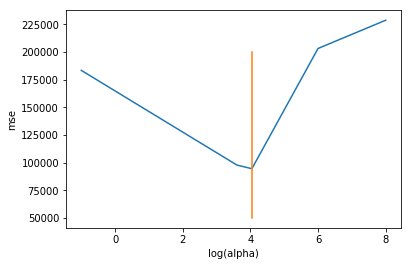

In [58]:
### 2.1 岭回归模型评价
mse_mean = np.mean(reg.cv_values_, axis=0)

#正则项参数取对数， mse_mean.reshape() 干什么的？拉平
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas), 1))
# 在最佳参数位置绘制竖线：注意第二个参数值要和 Y 坐标轴匹配
plt.plot(np.log10(reg.alpha_)*np.ones(3), [50000, 100000, 200000])
# plt.show() #绘制在一张图上，显示异常，暂时分开 

plt.xlabel('log(alpha)')
plt.ylabel('mse')

print('best alpha is:', reg.alpha_)

In [59]:
## 2.2 岭回归 模型与 Lasso 的比较
# 使用 RidgeCV 模型自带的评估模块（r2_score），并输出评估结果
#训练集
ridgeScoreTrain = reg.score(train_X, train_y)
print('The value of default measurement of RidgeRegression on train is', ridgeScoreTrain) 
print('ridgeScoreTrain - lassoScoreTrain = ', ridgeScoreTrain - lassoScoreTrain)
# The value of default measurement of RidgeRegression on train is 0.633948526875
# ridgeScoreTrain - lrScoreTrain =  -0.131696775147

The value of default measurement of RidgeRegression on train is 0.646343755488
ridgeScoreTrain - lassoScoreTrain =  0.0158129409951


In [60]:
#对测试数据进行预测
ridge_y_predict_test = reg.predict(test_X)
print('ridge_y_predict_test = ', ridge_y_predict_test)

# 标准化数据还原 
ridge_y_predict_test = inverse_StandardScaler(ridge_y_predict_test)

ridge_y_predict_test =  [-21.59769684 -25.98410601 -24.94383111 ..., -20.7879469  -25.00858034
 -24.94271106]


In [61]:
#输出预测后的数据
testPredict = generate_summit(ridge_y_predict_test)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


In [62]:
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, 'RidgeCV', out_id), index=False)
out_id += 1
testPredict.shape

(828934, 2)